# ScRNA-Seq of human bone marrow cells

<br>Data from [Oetjen, KA. et al.](https://insight.jci.org/articles/view/124928)
<br>Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3396176 

In [1]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp

In [2]:
# Path of data
file_base = '../../../../../data/raw/immune_cells/bone_marrow_human/GSM3396176_P/'
count_file_end = 'GSM3396176_matrix_P.mtx.gz'
gene_data_end = 'GSM3396176_genes_P.tsv.gz'
barcode_data_end = 'GSM3396176_barcodes_P.tsv.gz'

count_data = file_base+count_file_end
gene_data = file_base+gene_data_end
barcode_data = file_base+barcode_data_end

# Read data
adata = dp.read_sc_data(count_data, gene_data, barcode_data)

adata.var_names_make_unique()

In [3]:
print(adata.X.shape)
print(adata)

(3383, 33694)
AnnData object with n_obs × n_vars = 3383 × 33694
    var: 'gene_id'


In [4]:
adata.var.head()

,gene_id
gene_symbol,
RP11-34P13.3,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


## Preprocessing

In [5]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                    n_counts  log_n_counts  n_genes  log_n_genes  \
barcode                                                            
AAACCTGAGAGAGCTC-1    5535.0      8.619027     1362     7.217443   
AAACCTGAGGCAAAGA-1    6105.0      8.717028     1286     7.160069   
AAACCTGCACGAGGTA-1    6150.0      8.724370     1502     7.315218   
AAACCTGGTCCGAATT-1    4978.0      8.512984     1190     7.082549   
AAACCTGTCCTAAGTG-1    5206.0      8.557759     1355     7.212294   
...                      ...           ...      ...          ...   
TTTGTCAAGCTGCGAA-1   19977.0      9.902387     1965     7.583756   
TTTGTCAAGTTAGCGG-1   12229.0      9.411647     1872     7.535297   
TTTGTCAGTTCCCTTG-1   11235.0      9.326879     2052     7.627057   
TTTGTCATCGTCCAGG-1    5013.0      8.519989     1393     7.239933   
TTTGTCATCTGGAGCC-1    8148.0      9.005651      670     6.508769   

                    pct_counts_in_top_20_genes   mt_frac  ribo_frac  hem_frac  
barcode                            

In [6]:
qc_adata = dp.QC().QC_filter_outliers(adata,[5,5,3,5])

Number of cells before QC filtering: 3383
Number of cells removed by log_n_genes filtering: 9
Number of cells removed by log_n_counts filtering: 11
Number of cells removed by pct_counts_in_top_20_genes filtering: 1251
Number of cells removed by mt_frac filtering: 5
Number of cells post QC filtering: 2115
Number of genes before filtering: 33694
Number of genes after filtering so theres min 20 unique cells per gene: 12775


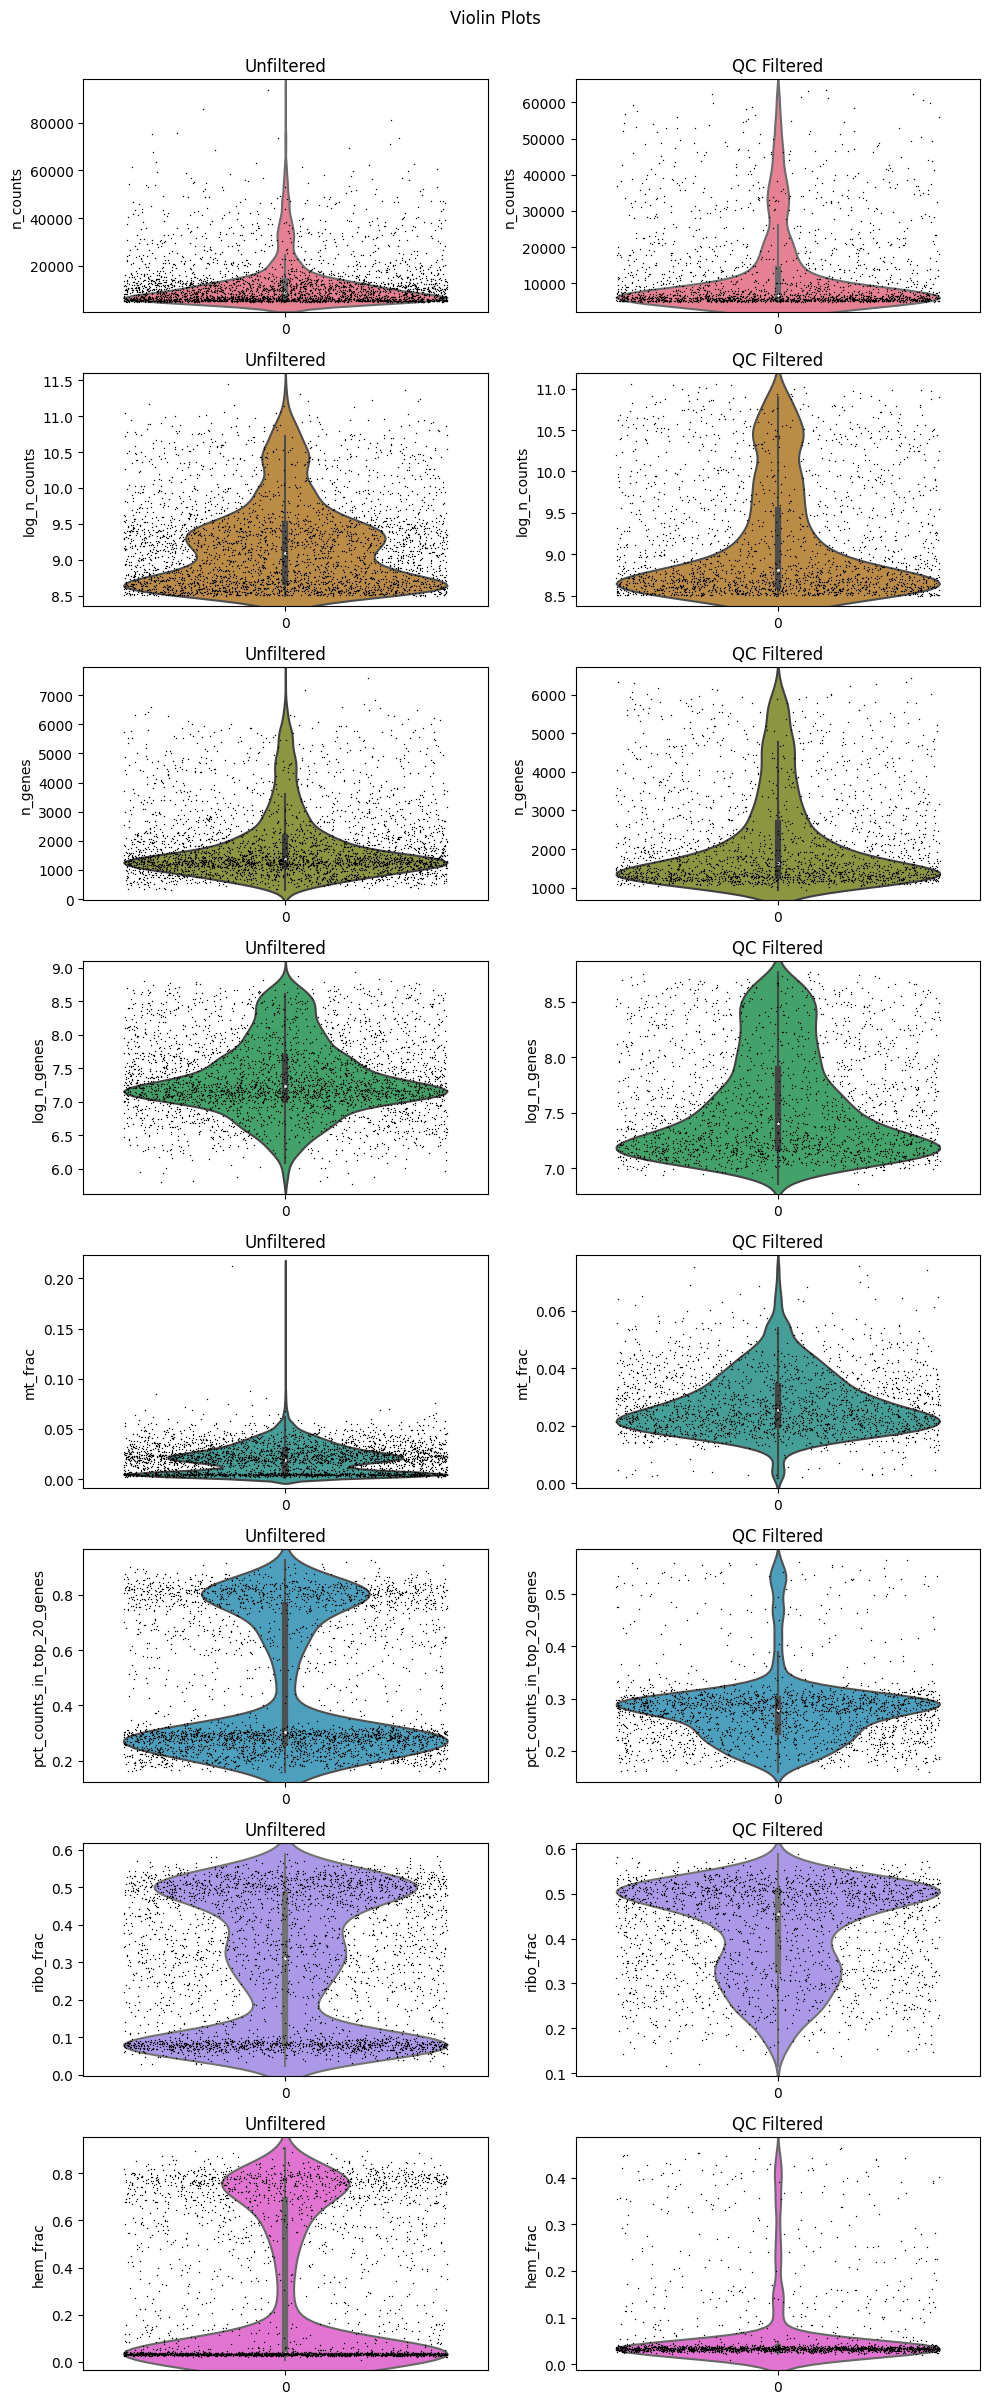

In [7]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes','ribo_frac','hem_frac'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

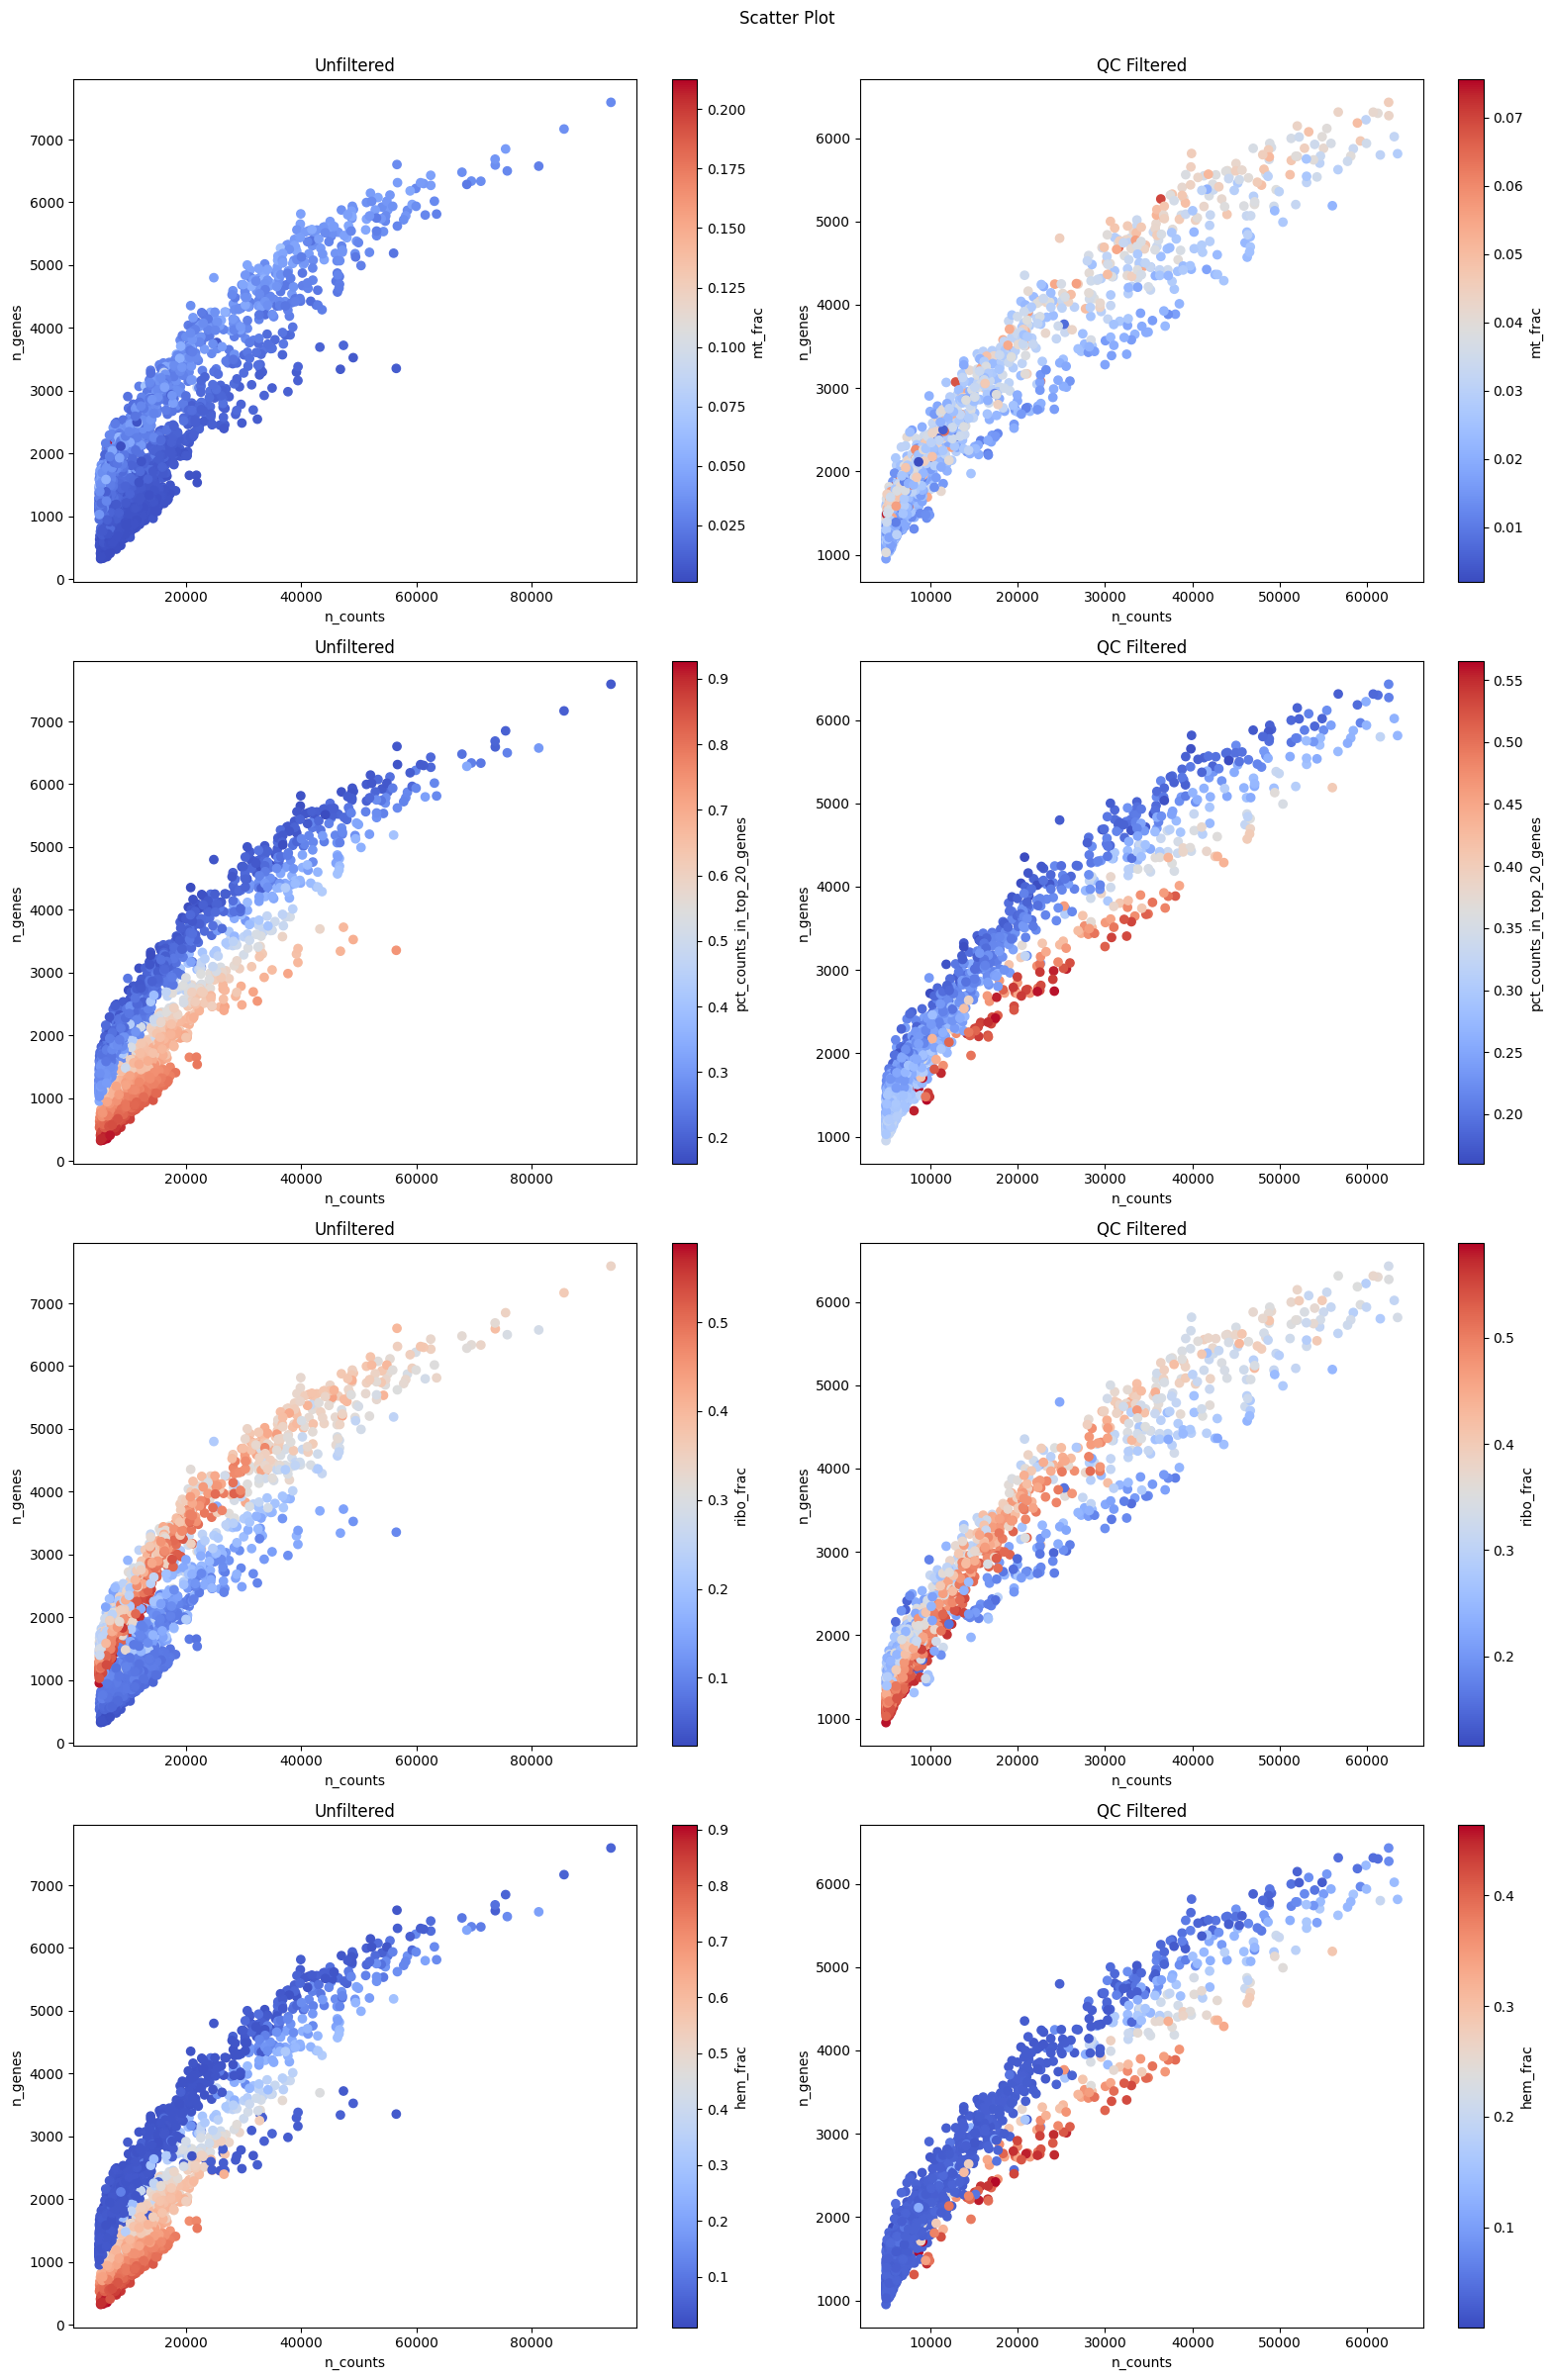

In [8]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [9]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [10]:
norm_qc_adata

AnnData object with n_obs × n_vars = 2115 × 12775
    obs: 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'ribo_frac', 'hem_frac', 'outlier', 'size_factors'
    var: 'gene_id', 'n_cells'
    layers: 'pp_counts', 'log1p_counts'

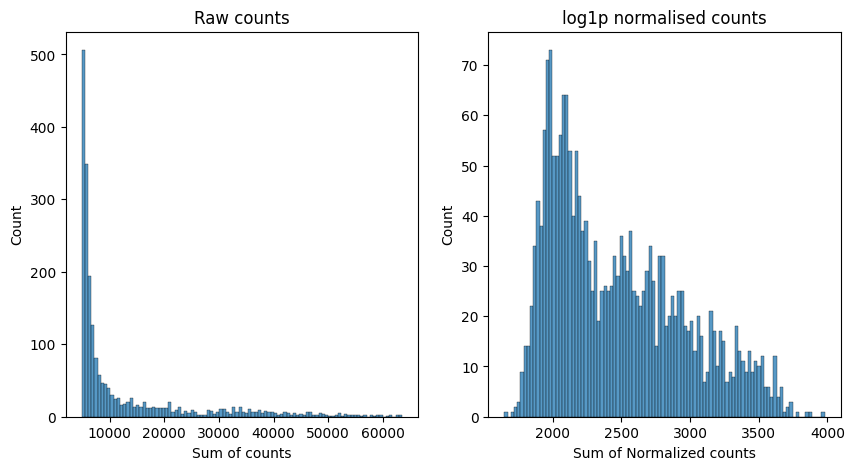

In [11]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [12]:
# Download normalized count matrix
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
HVG_data = norm_qc_adata[:, norm_qc_adata.var["highly_variable"]]
normalized_counts = pd.DataFrame(HVG_data.layers["log1p_counts"])
normalized_counts.index = HVG_data.obs.index.to_list()
normalized_counts.columns = HVG_data.var.index.to_list()
normalized_counts.to_csv("BM_2.csv")
norm_qc_adata.write("BM_2_adata.h5ad")